# Generative Models PHW1

Name: Mohammad Mohammadi

Student ID: 402208592

In [78]:
# Import necessary libraries
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
import scipy.io as sio
import itertools

# Markov Random Field (10 points)

Consider a 2D image made of binary pixels. Now, suppose you have a noisy version of this image where each pixel has a 0.1 probability of flipping its value. In the figure below, a sample real and noisy image is displayed. In this problem, the goal is to recover the original image by observing the noisy image using a Markov random field.
The energy function of the network on this set of variables is defined as follows:
$$E=\alpha \sum_i  x_i  -\beta \sum_{i,j}x_{i}x_{j} -\gamma \sum_i x_i y_i$$

where the parameters need to be tuned. Based on the image provided in the file `HW1_image.mat`, you must find the real value of each pixel based on its noisy counterpart shown in the file.
To do this, find the optimal value for the above energy function. First, initialize the real pixel values (i.e., $x_i$) with their noisy values given in the file. Then, sequentially check if assigning the value +1 or -1 to each pixel decreases the energy function. Repeat this process until the energy function converges.
- Display the recovered image and report the numeric value of your accuracy.
- Discuss the effect of increasing or decreasing each of the three model parameters and for one of the parameters, demonstrate this effect by changing it and recovering the image again.
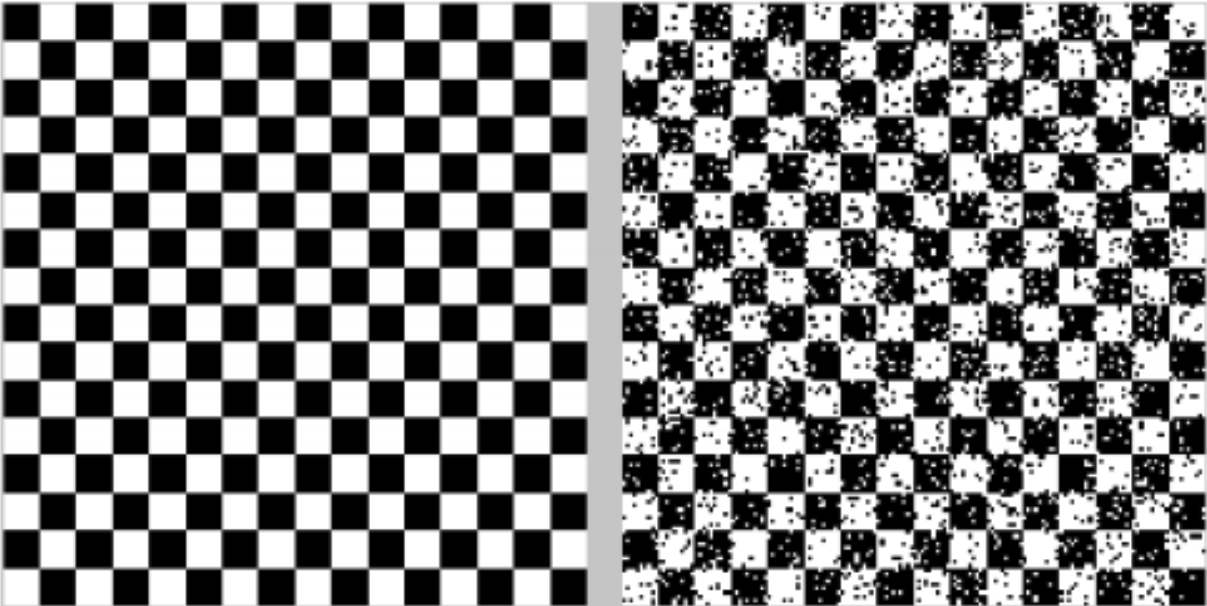

In [76]:
class MarkovRandomFieldDenoising:
    def __init__(self, image_file):
        self.load_data(image_file)
        self.initialize_parameters()

    def load_data(self, image_file):
        # TODO: Load the noisy image data from the provided file
        data = sio.loadmat(image_file)
        self.noisy_image = data['noisy_image'].astype(np.int32) # To prevent from loading as uint8
        self.true_image = data['original_image'].astype(np.int32) # To prevent from loading as uint8
        # Mapping pixel values from 0,1 to -1,1 for computation
        self.noisy_image = 2 * self.noisy_image - 1
        self.true_image = 2 * self.true_image - 1
        self.height, self.width = self.noisy_image.shape # Getting and storing height and width

    def initialize_parameters(self):
        # TODO: Initialize the parameters for the Markov random field
        # Set of parameter values I found effective
        self.alpha = -0.001
        self.beta = 100
        self.gamma = 10

    def energy_function(self, z):
        # TODO: Implement the energy function
        first_term = np.sum(z)
        last_term = np.sum(z * self.noisy_image)
        # Computing middle term (by interaction with neighbors)
        middle_term = 0
        for i in range(self.height):
            for j in range(self.width):
                if i < self.height - 1:
                    middle_term += z[i, j] * z[i + 1, j]
                if j < self.width - 1:
                    middle_term += z[i, j] * z[i, j + 1]
        # Total energy
        energy = self.alpha * first_term - self.beta * middle_term - self.gamma * last_term
        return energy

    def denoise_image(self):
        # TODO: Implement the denoising algorithm
        # z is the denoised_image just in shorter naming
        z = self.noisy_image.copy()
        energy = self.energy_function(z)
        old_energy = energy + 100  # Initialize with a higher energy to start the loop
        
        converged = False
        while not converged:
            old_energy = energy
            for i in range(self.height):
                for j in range(self.width):
                    flip = -1 if z[i, j] == 1 else 1
                    first_term = flip - z[i, j]
                    last_term = flip * self.noisy_image[i, j] - z[i, j] * self.noisy_image[i, j]
                    middle_term = 0

                    # Check neighbors and compute middle term changes
                    neighbors = []
                    if i > 0:
                        neighbors.append((i - 1, j))
                    if i < self.height - 1:
                        neighbors.append((i + 1, j))
                    if j > 0:
                        neighbors.append((i, j - 1))
                    if j < self.width - 1:
                        neighbors.append((i, j + 1))

                    for ni, nj in neighbors:
                        middle_term += flip * z[ni, nj] - z[i, j] * z[ni, nj]

                    # Calculate new energy
                    delta_energy = self.alpha * first_term - self.beta * middle_term - self.gamma * last_term
                    new_energy = energy + delta_energy

                    # If energy is reduced, accept the flip
                    if new_energy < energy:
                        energy = new_energy
                        z[i, j] = flip
            converged = not (old_energy - energy > 1)

        return z

    def compute_accuracy(self, denoised_image):
        # TODO: Compute the accuracy of the denoised image
        accuracy = np.mean(denoised_image == self.true_image)
        return accuracy

    def plot_images(self, denoised_image):
        # TODO: Plot the noisy, true, and denoised images
        
        # Map images back to 0 and 1 for the sake of display
        noisy_image_display = (self.noisy_image + 1) / 2
        true_image_display = (self.true_image + 1) / 2
        denoised_image_display = (denoised_image + 1) / 2

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Noisy Image')
        plt.imshow(noisy_image_display, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title('True Image')
        plt.imshow(true_image_display, cmap='gray')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.title('Denoised Image')
        plt.imshow(denoised_image_display, cmap='gray')
        plt.axis('off')
        plt.show()


Accuracy: 0.9831640625


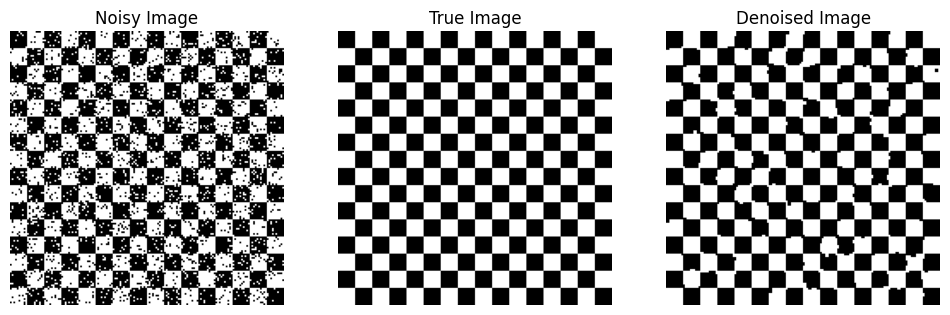

With beta = 0.1, Accuracy: 90.19%


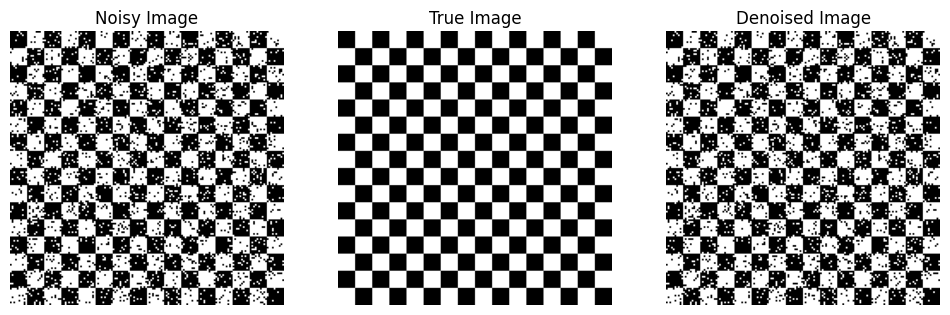

With beta = 1, Accuracy: 90.19%


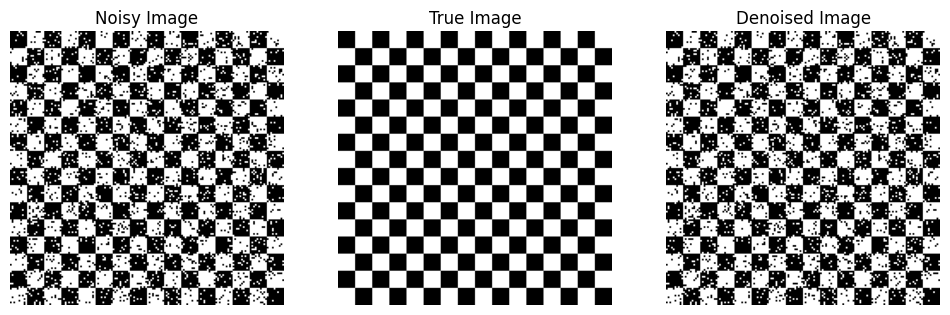

With beta = 10, Accuracy: 98.29%


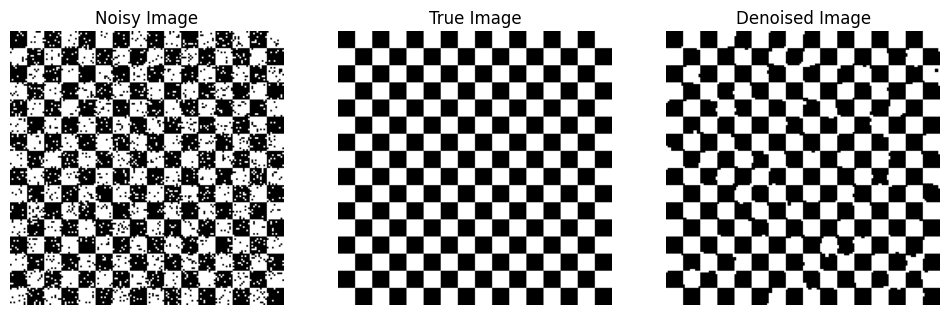

With beta = 100, Accuracy: 98.32%


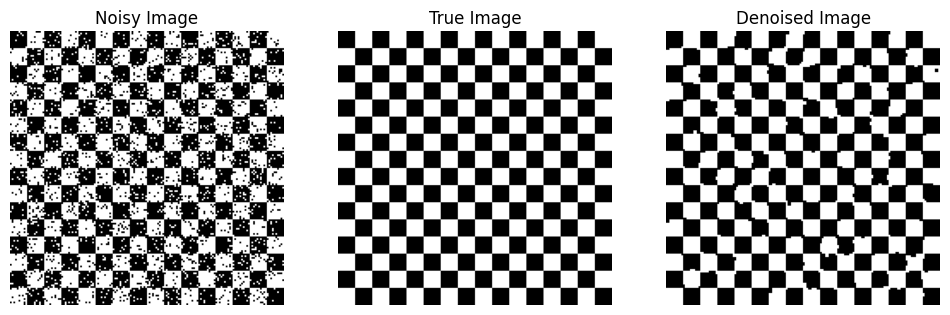

With beta = 1000, Accuracy: 98.32%


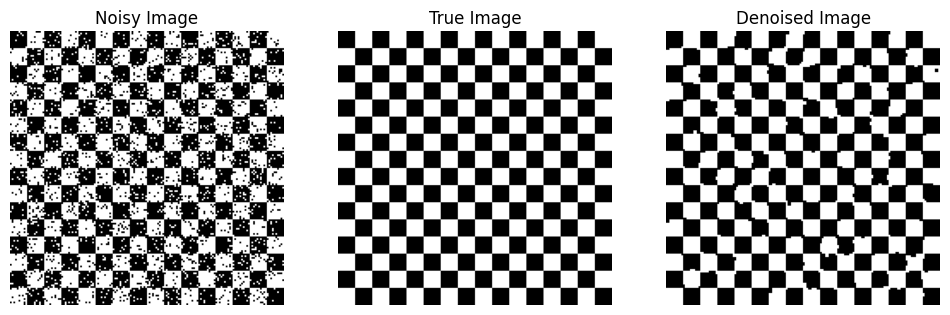

In [77]:
# Initialize the Markov Random Field Denoising with the image file
mrf_denoising = MarkovRandomFieldDenoising('HW1_image.mat')

# Denoise the image
denoised_image = mrf_denoising.denoise_image()

# Compute the accuracy
accuracy = mrf_denoising.compute_accuracy(denoised_image)
print(f"Accuracy: {accuracy}")

# Plot the images
mrf_denoising.plot_images(denoised_image)

# TODO: Discuss the effect of parameter changes and demonstrate with one parameter
# Changing the 'beta' parameter to see its effect
beta_values = [0.1, 1, 10, 100, 1000]
for beta in beta_values:
    mrf_denoising.beta = beta
    denoised_image = mrf_denoising.denoise_image()
    accuracy = mrf_denoising.compute_accuracy(denoised_image)
    print(f"With beta = {beta}, Accuracy: {accuracy * 100:.2f}%")
    mrf_denoising.plot_images(denoised_image)

# Bayesian Network (15 points)

Here we want to implement a Bayesian Network from scratch. The instructions are as follows:

1. `__init__` method:
  - Create a directed acyclic graph (DAG) using `networkx.DiGraph()`.
  - Set up an empty dictionary cpts to store the Conditional Probability Tables (CPTs) for each node.

2. `add_node` method:
	- Use `self.graph.add_node(node)` to add a node to the network graph.

3. `add_edge` method:
  - Use `self.graph.add_edge(parent, child)` to create a directed edge from the parent to the child node.

4. `set_cpt` method:
  - Assign the cpt (which is a dictionary) to the node in `self.cpts[node]`.

5. `draw_network` method:
	-	Use `nx.spring_layout(self.graph)` to arrange the nodes.
	-	Use `nx.draw()` to plot the nodes and edges with labels, and customize the layout.
	-	Display the network using `plt.show()`.

6. `joint_probability` method:
	-	For each node, get its value from `values[node]` and its parents using `self.graph.predecessors(node)`.
	-	If a node has no parents (a root node), multiply the probability from the node's CPT.
	-	If a node has parents, get the parent values, and multiply the conditional probability from its CPT.

7. `compute_posterior` method:
	-	Identify hidden nodes (those not in the query or evidence).
	-	Compute the denominator by summing the joint probability over all possible values of hidden nodes.
	-	Compute the numerator by summing the joint probability of the query and evidence over all hidden values.
	-	Return the ratio of numerator to denominator.

8. `variable_elimination` method:
	-	Initialize factors using `_initialize_factors()`, reducing the CPTs based on evidence.
	-	Identify the nodes to eliminate (all nodes except the query and evidence).
	-	Eliminate each variable by summing it out with `_sum_out()`.
	-	Multiply the remaining factors and normalize to get the final distribution.

9. `_initialize_factors` method:
	-	For each node, get its CPT from `self.cpts`.
	-	If the node has evidence, reduce the CPT using `_reduce_factor()`.
	-	Otherwise, include the CPT unchanged.

10. `_reduce_factor` method:
  - If the node has no parents, just return the CPT for the observed value.
	- If the node has parents, keep only the relevant rows from the CPT based on the observed value.

11. `_sum_out` method:
	-	Find factors that include the variable.
	-	Multiply those factors together.
	-	Use `_sum_out_factor()` to sum out the variable from the combined factor.

12. `_sum_out_factor` method:
	-	For each assignment of the variable, sum over the values where the variable appears.
	-	Create a new factor that does not include the variable.

13. `_multiply_factors` method:
	-	Start with the first factor.
	-	Multiply it with the next factor using `_multiply_two_factors()`, and continue multiplying the remaining factors.

14. `_multiply_two_factors` method:
	-	Combine each pair of assignments from both factors.
	-	Multiply the corresponding probabilities, and return the new combined factor.

15. `_normalize` method:
	-	Compute the sum of all values in the factor.
	-	Divide each value by the total to ensure the probabilities sum to 1.

In [94]:
class BayesianNetwork:
    def __init__(self):
        """Initialize the Bayesian network as a directed acyclic graph (DAG)"""
        self.graph = nx.DiGraph()
        self.cpts = {}  # Conditional Probability Tables (CPTs)

    def add_node(self, node):
        """Add a node to the network"""
        # TODO: Add node to the graph
        self.graph.add_node(node)

    def add_edge(self, parent, child):
        """Add a directed edge from parent to child"""
        # TODO: Add directed edge between nodes
        self.graph.add_edge(parent, child)

    def set_cpt(self, node, cpt):
        """Set the conditional probability table for a node"""
        # TODO: Assign CPT to the node
        self.cpts[node] = cpt

    def draw_network(self):
        """Draw the Bayesian network using networkx"""
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, with_labels=True, node_size=5000, node_color='lightblue', font_size=12, font_weight='bold')
        plt.title("Bayesian Network Structure")
        plt.show()

    def joint_probability(self, values):
        """Compute the joint probability P(values) for a set of node values."""
        # TODO: Implement joint probability computation
        prob = 1.0
        for node in self.graph.nodes():
            node_value = values[node]
            parents = list(self.graph.predecessors(node))
            cpt = self.cpts[node]
            if not parents:
                prob *= cpt[node_value]
            else:
                parent_values = tuple(values[parent] for parent in parents)
                prob *= cpt[parent_values][node_value]
        return prob

    def compute_posterior(self, query, evidence):
        """Compute the posterior probability P(query | evidence)."""
        # TODO: Compute posterior probability given query and evidence
        # Identify all variables
        all_vars = set(self.graph.nodes())
        # Variables to sum over (hidden variables)
        hidden_vars = all_vars - set(query.keys()) - set(evidence.keys())
        # Generate all possible combinations for hidden variables
        hidden_var_combinations = list(itertools.product([True, False], repeat=len(hidden_vars)))
        hidden_var_list = list(hidden_vars)

        numerator = 0.0
        denominator = 0.0

        for combination in hidden_var_combinations:
            # Build the full assignment
            assignment = dict(zip(hidden_var_list, combination))
            assignment.update(evidence)
            assignment.update(query)

            joint_prob = self.joint_probability(assignment)
            numerator += joint_prob

            # For denominator, only need to sum over all values of query
            assignment_denominator = dict(zip(hidden_var_list, combination))
            assignment_denominator.update(evidence)
            # Sum over all possible values of query variables
            for query_values in itertools.product([True, False], repeat=len(query)):
                assignment_q = dict(zip(query.keys(), query_values))
                assignment_denominator.update(assignment_q)
                joint_prob_denominator = self.joint_probability(assignment_denominator)
                denominator += joint_prob_denominator

        # Compute posterior probability
        posterior = numerator / denominator if denominator != 0 else 0
        return posterior

    def variable_elimination(self, query, evidence):
        """Perform exact inference using variable elimination."""
        # TODO: Implement variable elimination method
        factors = self._initialize_factors(evidence)
        variables_to_eliminate = [var for var in self.graph.nodes() if var not in query and var not in evidence]
        for var in variables_to_eliminate:
            factors = self._sum_out(var, factors)
        final_factor = self._multiply_factors(factors)
        normalized_factor = self._normalize(final_factor)
        # Return the probabilities for the query variables
        query_vars = list(query.keys())
        # Extract the relevant probabilities
        result = {assignment: prob for assignment, prob in normalized_factor['probabilities'].items() if all(assignment[var] == query[var] for var in query_vars)}
        return result

    def _initialize_factors(self, evidence):
        """Initialize factors, incorporating evidence."""
        # TODO: Initialize factors by reducing CPTs based on evidence
        factors = []
        for node in self.graph.nodes():
            cpt = self.cpts[node]
            parents = list(self.graph.predecessors(node))
            if node in evidence:
                reduced_cpt = self._reduce_factor(cpt, node, evidence[node], parents)
                factors.append(reduced_cpt)
            else:
                factor = {
                    'variables': [node] + parents,
                    'probabilities': {}
                }
                if not parents:
                    # Node has no parents
                    for value in [True, False]:
                        factor['probabilities'][(value,)] = cpt[value]
                else:
                    # Node has parents
                    for parent_values in itertools.product([True, False], repeat=len(parents)):
                        for value in [True, False]:
                            key = parent_values + (value,)
                            factor['probabilities'][key] = cpt[parent_values][value]
                factors.append(factor)
        return factors

    def _reduce_factor(self, cpt, node, value, parents):
        """Reduce the factor (CPT) based on evidence."""
        # TODO: Reduce CPT based on evidence
        factor = {
            'variables': parents,
            'probabilities': {}
        }
        if not parents:
            # Node has no parents, return empty factor
            return None
        else:
            # Node has parents
            for parent_values in itertools.product([True, False], repeat=len(parents)):
                if cpt[parent_values][value] > 0:
                    factor['probabilities'][parent_values] = cpt[parent_values][value]
        return factor

    def _sum_out(self, var, factors):
        """Sum out the variable from the list of factors."""
        # TODO: Sum out variable from factors
        factors_with_var = [f for f in factors if f and var in f['variables']]
        factors_without_var = [f for f in factors if f and var not in f['variables']]
        if factors_with_var:
            multiplied_factor = self._multiply_factors(factors_with_var)
            summed_factor = self._sum_out_factor(multiplied_factor, var)
            factors = factors_without_var + [summed_factor]
        return factors

    def _sum_out_factor(self, factor, var):
        """Sum out a variable from a factor."""
        # TODO: Implement sum-out operation for factors
        new_variables = [v for v in factor['variables'] if v != var]
        new_probabilities = {}
        for assignment in factor['probabilities']:
            new_assignment = {v: assignment[i] for i, v in enumerate(factor['variables']) if v != var}
            new_assignment_key = tuple(new_assignment[v] for v in new_variables)
            if new_assignment_key in new_probabilities:
                new_probabilities[new_assignment_key] += factor['probabilities'][assignment]
            else:
                new_probabilities[new_assignment_key] = factor['probabilities'][assignment]
        new_factor = {
            'variables': new_variables,
            'probabilities': new_probabilities
        }
        return new_factor

    def _multiply_factors(self, factors):
        """Multiply a list of factors."""
        # TODO: Multiply a list of factors
        from functools import reduce
        return reduce(self._multiply_two_factors, factors)

    def _multiply_two_factors(self, factor1, factor2):
        """Multiply two factors."""
        # TODO: Multiply two factors
        variables = list(set(factor1['variables'] + factor2['variables']))
        new_probabilities = {}
        for assignment in itertools.product([True, False], repeat=len(variables)):
            assignment_dict = dict(zip(variables, assignment))
            # Extract relevant assignments for each factor
            assignment1 = tuple(assignment_dict[v] for v in factor1['variables'])
            assignment2 = tuple(assignment_dict[v] for v in factor2['variables'])
            prob1 = factor1['probabilities'].get(assignment1, 0)
            prob2 = factor2['probabilities'].get(assignment2, 0)
            new_probabilities[assignment] = prob1 * prob2
        new_factor = {
            'variables': variables,
            'probabilities': new_probabilities
        }
        return new_factor


    def _normalize(self, factor):
        """Normalize a factor to get a probability distribution."""
        # TODO: Normalize the factor
        total = sum(factor['probabilities'].values())
        if total == 0:
            return factor
        for assignment in factor['probabilities']:
            factor['probabilities'][assignment] /= total
        return factor

## Example
Here you must implement the following network using the `BayesianNetwork()` class you wrote:

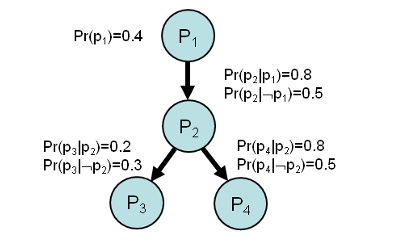

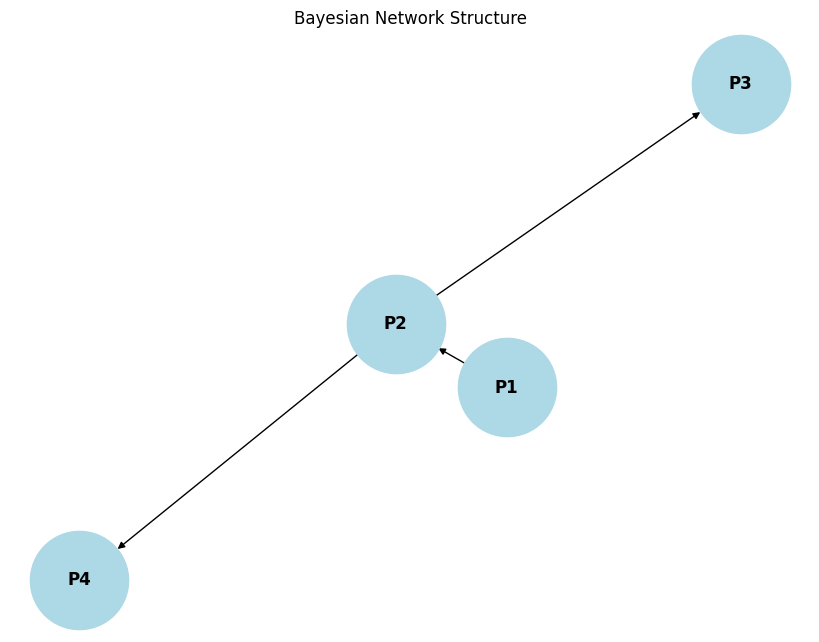

In [95]:
# TODO: Create a generic Bayesian network
bn = BayesianNetwork()

# TODO: Add nodes
bn.add_node('P1')
bn.add_node('P2')
bn.add_node('P3')
bn.add_node('P4')

# TODO: Add edges
bn.add_edge('P1', 'P2')
bn.add_edge('P2', 'P3')
bn.add_edge('P2', 'P4')

# TODO: Visualize the network structure
bn.draw_network()

Now fill in the Conditional Probability Tables (CPTs).

In [100]:
# TODO: Define the CPTs for each node

P1 = {
    1: 0.4, 0: 0.6
}

P2 = {
    (1,): {1: 0.8, 0: 0.2},
    (0,): {1: 0.5, 0: 0.5}
}

P3 = {
    (1,): {1: 0.2, 0: 0.8},
    (0,): {1: 0.3, 0: 0.7}
}

P4 = {
    (1,): {1: 0.8, 0: 0.2},
    (0,): {1: 0.5, 0: 0.5}
}

# Set the CPTs for each node in the network
bn.set_cpt('P1', P1)
bn.set_cpt('P2', P2)
bn.set_cpt('P3', P3)
bn.set_cpt('P4', P4)
# bn.draw_network()

### Question 1

Calculate $Pr(p_1 , p_2, \neg p_3, p_4)$ by using the `joing_probability(values)` method.

In [106]:
values = {'P1': 1, 'P2': 1, 'P3': 0, 'P4': 1}
jp = bn.joint_probability(values)
print(f"P{values} = {jp:.4f}")

P{'P1': 1, 'P2': 1, 'P3': 0, 'P4': 1} = 0.2048


### Question 2

Calculate $Pr(p_2, \neg p_3)$ by using the `compute_posterior(query, evidence)` method.

In [102]:
query = {'P2': 1, 'P3': 0}
evidence = {}
posterior = bn.compute_posterior(query, evidence)
print(f'P({query}) = {posterior:.3f}')

P({'P2': 1, 'P3': 0}) = 0.496


### Question 3
Calculate $Pr(p_1 | p_2, \neg p_3)$ by using the `compute_posterior(query, evidence)` method.

In [104]:
# Example: Compute the posterior for a query and evidence pair
query = {'P1': 1}
evidence = {'P2': 1, 'P3': 0}
posterior = bn.compute_posterior(query, evidence)
print(f'P({query} | {evidence}) = {posterior:.3f}')

P({'P1': 1} | {'P2': 1, 'P3': 0}) = 0.516


## Sampling

### Rejection Sampling

In [116]:
def rejection_sampling(bn, evidence, num_samples):
    """Rejection sampling for the given Bayesian network."""
    # Getting variables in topological order and
    # Identifying all variables in topological order
    variables = list(nx.topological_sort(bn.graph))
    # Identify non-evidence variables
    non_evidence_vars = [var for var in variables if var not in evidence]
    # Counts for all possible assignments of non-evidence variables
    sample_space = list(itertools.product([1, 0], repeat=len(non_evidence_vars)))
    samples = {assignment: 0 for assignment in sample_space}
    accepted_samples = 0

    while accepted_samples < num_samples:
        assignment = {}
        for var in variables:
            parents = list(bn.graph.predecessors(var))
            if not parents:
                prob_true = bn.cpts[var][1]
            else:
                parent_values = tuple(assignment[parent] for parent in parents)
                prob_true = bn.cpts[var][parent_values][1]
            # Sample the variable: 1 with probability prob_true, else 0
            assignment[var] = 1 if np.random.rand() < prob_true else 0
        
        # If assignment matches the evidence
        match = True
        for var, val in evidence.items():
            if assignment.get(var, None) != val:
                match = False
                break
        
        if match:
            # Extracting values of non-evidence variables in order
            non_evidence_values = tuple(assignment[var] for var in non_evidence_vars)
            samples[non_evidence_values] += 1
            accepted_samples += 1
    
    print(f"Total Accepted Samples: {accepted_samples}")
    print("Sample Counts for Non-Evidence Variables:")
    for assignment, count in samples.items():
        print(f"{assignment}: {count}")

In [117]:
evidence = {'P3': 0}
# Accepted samples to collect
num_samples = 1000
rejection_sampling(bn, evidence, num_samples)

Total Accepted Samples: 1000
Sample Counts for Non-Evidence Variables:
(1, 1, 1): 271
(1, 1, 0): 61
(1, 0, 1): 34
(1, 0, 0): 35
(0, 1, 1): 269
(0, 1, 0): 60
(0, 0, 1): 136
(0, 0, 0): 134


### Gibbs Sampling

In [119]:
def gibbs_sampling(bn, initial_sample, num_iterations):
    """Gibbs sampling for the Bayesian network."""
    # Identifying all variables
    variables = list(nx.topological_sort(bn.graph))
    # Identifying evidence and non-evidence variables
    evidence_vars = set(initial_sample.keys())
    non_evidence_vars = [var for var in variables if var not in evidence_vars]
    # Initializing current sample
    sample = initial_sample.copy()
    # Assigning initial values to non-evidence variables if not provided
    for var in non_evidence_vars:
        if var not in sample:
            sample[var] = np.random.choice([1, 0])
    
    # Counts for all possible assignments of non-evidence variables
    sample_space = list(itertools.product([1, 0], repeat=len(non_evidence_vars)))
    samples = {assignment: 0 for assignment in sample_space}
    # Recording the initial assignment
    non_evidence_values = tuple(sample[var] for var in non_evidence_vars)
    samples[non_evidence_values] += 1
    
    for iteration in range(num_iterations):
        for var in non_evidence_vars:
            # Markov Blanket: parents, children, and children's other parents
            parents = list(bn.graph.predecessors(var))
            children = list(bn.graph.successors(var))
            children_parents = {child: list(bn.graph.predecessors(child)) for child in children}
            
            # Computing both P(var=1 | Markov Blanket) and P(var=0 | Markov Blanket)
            probs = {}
            for value in [1, 0]:
                # Probability of var given its parents
                if not parents:
                    p_var = bn.cpts[var][value]
                else:
                    parent_values = tuple(sample[parent] for parent in parents)
                    p_var = bn.cpts[var][parent_values][value]
                # Multiply by the probabilities of the children given their parents
                p_children = 1.0
                for child in children:
                    child_parents = children_parents[child]
                    child_parent_values = tuple(sample[parent] if parent != var else value for parent in child_parents)
                    p_child = bn.cpts[child][child_parent_values][sample[child]]
                    p_children *= p_child
                probs[value] = p_var * p_children
            
            # Normalization of  probabilities
            total = probs[1] + probs[0]
            if total == 0:
                normalized_prob_true = 0.5
            else:
                normalized_prob_true = probs[1] / total
            # Sampling new value for the variable
            sample[var] = 1 if np.random.rand() < normalized_prob_true else 0
        
        # After updating all variables, record the current assignment
        non_evidence_values = tuple(sample[var] for var in non_evidence_vars)
        samples[non_evidence_values] += 1
    print(f"Samples after {num_iterations} iterations:")
    for assignment, count in samples.items():
        print(f"{assignment}: {count}")

In [120]:
evidence = {'P3': 0}
# Accepted samples to collect
num_samples = 1000
gibbs_sampling(bn, evidence, num_samples)

Samples after 1000 iterations:
(1, 1, 1): 288
(1, 1, 0): 73
(1, 0, 1): 40
(1, 0, 0): 32
(0, 1, 1): 229
(0, 1, 0): 62
(0, 0, 1): 143
(0, 0, 0): 134
